In [1]:
import socket
from time import time
import argparse
import torch
import torch.optim as optim
import networkx as nx
from tqdm import tqdm
from hyperbolicity.delta import compute_hyperbolicity_batch, compute_hyperbolicity
from hyperbolicity.utils import soft_max, floyd_warshall, soft_max, construct_weighted_matrix, make_batches
from hyperbolicity.tree_fitting_methods.gromov import gromov_tree
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
base_path = '../datasets'

c_elegan = 'D_celegan.pkl'
c_elegan_path = os.path.join(base_path, c_elegan)
with open(c_elegan_path, 'rb') as f:
    distances = pickle.load(f)
distances = torch.tensor(distances).to('cuda').type(torch.float32)

In [8]:
path = '/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/results_expes/expe_celegan_gpu_batch_32/expe_celegan_gpu/launch_distance_hyperbolicity_learning_2025_04_23_18_06_39-run_number-0-dataset-celegan-learning_rate-0.01-distance_reg-0.001-scale_delta-1.0-epochs-500-batch_size-32-n_batches-50-gpu-True/res.pickle'

In [9]:
with open(path, 'rb') as f:
    data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/results_expes/expe_celegan_gpu_batch_32/expe_celegan_gpu/launch_distance_hyperbolicity_learning_2025_04_23_18_06_39-run_number-0-dataset-celegan-learning_rate-0.01-distance_reg-0.001-scale_delta-1.0-epochs-500-batch_size-32-n_batches-50-gpu-True/res.pickle'

In [4]:
def train_distance_matrix(distances: torch.Tensor,
                          scale_delta: float,
                          distance_reg: float,
                          num_epochs: int,
                          n_batches: int,
                          batch_size: int,
                          learning_rate: float,
                          verbose: bool):

    num_nodes = distances.shape[0]
    edges = torch.triu_indices(num_nodes, num_nodes, offset=1)
    upper_adjency = torch.triu(distances, diagonal=1).type(torch.float32)
    true_upper = upper_adjency[upper_adjency != 0].to('cuda').detach().clone()
    weights_opt = true_upper.clone().requires_grad_(True)
    
    
    optimizer = optim.AdamW([weights_opt], lr=learning_rate, weight_decay=0)
    losses = []
    deltas = []
    errors = []


    def projection(weight, num_nodes, edges):
        update_dist = construct_weighted_matrix(weight, num_nodes, edges)
        update_dist = floyd_warshall(update_dist)

        return torch.triu(update_dist, diagonal=1)[torch.triu(update_dist, diagonal=1) != 0]#, pairs


    def loss_fn(w):
        update_dist = construct_weighted_matrix(w, num_nodes, edges)
        M_batch = make_batches(update_dist, size_batches=batch_size, nb_batches=n_batches)
        #delta = soft_max(compute_hyperbolicity_batch(M_batch, scale=scale_delta), scale=scale_soft_max)
        delta = soft_max(compute_hyperbolicity_batch(M_batch, scale=scale_delta), scale=scale_delta)
        #delta = delta.mean()
        #err = soft_max(torch.abs(distances.flatten()-update_dist.flatten()), scale=scale_soft_max)
        err = (distances-update_dist).pow(2).mean()

        return delta + distance_reg*err, delta, err

    patience = 30
    best_loss = float('inf')
    patience_counter = 0

    with tqdm(range(num_epochs), desc="Training Weights", disable=not verbose) as pbar:
        for epoch in pbar:
            optimizer.zero_grad()
            loss, delta, err = loss_fn(weights_opt)

            pbar.set_description(f"loss = {loss.item():.5f}, delta = {delta:.5f}, error = {err:.5f}")
            if torch.isnan(loss):
                raise NanError('Loss is Nan')
            losses.append(loss.item())
            deltas.append(delta.item())
            errors.append(err.item())

            if loss.item() < best_loss:
                best_loss = loss.item()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

            loss.backward()
            torch.nn.utils.clip_grad_norm_([weights_opt], max_norm=1.0)
            optimizer.step()

            with torch.no_grad():
                weights_opt.data = projection(weights_opt, num_nodes, edges)

    return weights_opt.detach().clone(), losses, deltas, errors

In [5]:
scale = 1
distance_reg = 0.001
num_epochs = 500
batch_size = 25
n_batches = 50
learning_rate = 0.01


weights, losses, deltas, errors = train_distance_matrix(distances,
                                                scale_delta=1,
                                                distance_reg=distance_reg,
                                                num_epochs=num_epochs,
                                                batch_size=batch_size,
                                                n_batches=n_batches,
                                                learning_rate=learning_rate,
                                                verbose=True)

loss = 16.79582, delta = 16.79568, error = 0.14950:  98%|█████████▊| 488/500 [00:57<00:01,  8.45it/s]

Early stopping triggered.


LSE
scale = 100000
distance_reg = 0.001
num_epochs = 500
batch_size = 25
n_batches = 50
learning_rate = 0.01


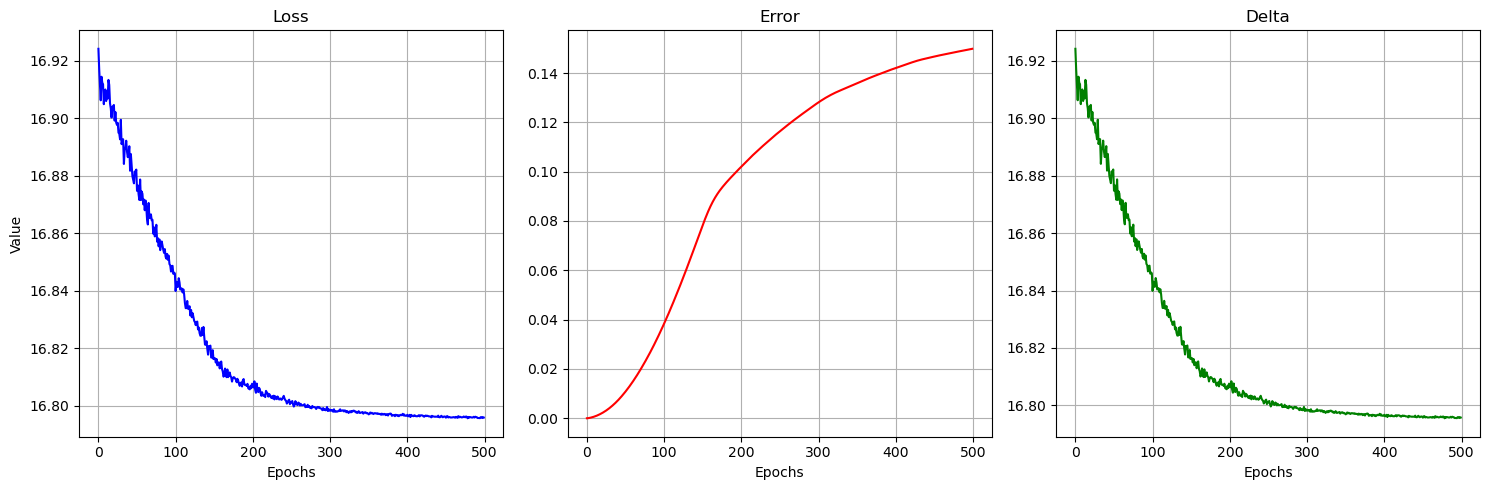

In [32]:
print('LSE')
print(f"scale = {scale}")
print(f"distance_reg = {distance_reg}")
print(f"num_epochs = {num_epochs}")
print(f"batch_size = {batch_size}")
print(f"n_batches = {n_batches}")
print(f"learning_rate = {learning_rate}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(losses, label='Loss', color='blue')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Value')
axs[0].grid()

axs[1].plot(errors, label='Error', color='red')
axs[1].set_title('Error')
axs[1].set_xlabel('Epochs')
axs[1].grid()

axs[2].plot(deltas, label='Delta', color='green')
axs[2].set_title('Delta')
axs[2].set_xlabel('Epochs')
axs[2].grid()
plt.tight_layout()


In [33]:
num_nodes = distances.shape[0]
edges = torch.triu_indices(num_nodes, num_nodes, offset=1)
intermediate_distances = construct_weighted_matrix(weights, num_nodes, edges)

In [34]:
indices = np.random.choice(distances.shape[0], size=100, replace=False)

In [35]:
mean_optim = []
l1_error_optim = []
#for j in range(distances.shape[0]):
for j in indices:
    tree_optim = gromov_tree(intermediate_distances.cpu().numpy(), j)
    mean_optim.append(np.abs(tree_optim - distances.cpu().numpy()).max())
    l1_error_optim.append((2/(num_nodes*(num_nodes-1)))*np.abs(tree_optim - distances.cpu().numpy()).sum())

In [37]:
mean_optim_value = np.mean(mean_optim)
min_optim_value = np.min(mean_optim)
print(f"Mean Optimized: {mean_optim_value:.4f}, Std Dev Optimized: {np.std(mean_optim):.4f}")
print(f"Minimum Optimized: {min_optim_value:.4f}")
mean_l1_error_optim = np.min(l1_error_optim)
print(f"Min L1 Error Optimized: {mean_l1_error_optim/2:.4f}")

Mean Optimized: 2.4452, Std Dev Optimized: 0.1240
Minimum Optimized: 2.3128
Min L1 Error Optimized: 0.5376


In [30]:
torch.abs(intermediate_distances - distances).max(), torch.abs(intermediate_distances - distances).mean()

(tensor(1.6808, device='cuda:0'), tensor(0.3146, device='cuda:0'))

In [39]:
l1_error_no_optim = []
mean_no_optim = []
# for j in range(distances.shape[0]):
for j in indices:
    tree_no_optim = gromov_tree(distances.cpu().numpy(), j)
    mean_no_optim.append(np.abs(tree_no_optim - distances.cpu().numpy()).max())
    l1_error_no_optim.append((2/(num_nodes*(num_nodes-1)))*np.abs(tree_no_optim - distances.cpu().numpy()).sum())


In [40]:
mean_no_optim_value = np.mean(mean_no_optim)
print(f"Mean No Optimized: {mean_no_optim_value:.4f}, Std Dev No Optimized: {np.std(mean_no_optim):.4f}")
print(f"Minimum No Optimized: {np.min(mean_no_optim):.4f}")
mean_l1_error_no_optim = np.min(l1_error_no_optim)
print(f"Min L1 Error No Optimized: {mean_l1_error_no_optim/2:.4f}")

Mean No Optimized: 3.3300, Std Dev No Optimized: 0.4702
Minimum No Optimized: 3.0000
Min L1 Error No Optimized: 1.0261
